In [1]:
# Imports 

import networkx as nx
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [30]:
COUNT = 'count'

# Parameters
growth_rate = 0.01
death_rate = 0.00
expulsion_rate = 0.0

initial_load = 100
initial_infected_node = 0

time_limit = 10

split_method = 'even'

In [3]:
# Network
bronchial_tree = nx.Graph()

# Trachea
bronchial_tree.add_edge(0,1)
origin = 0

# MAIN (PRIMARY) BRONCHI
bronchial_tree.add_edges_from([(1,2), (2,3), (1,4)])

# LOBAR BRONCHI
bronchial_tree.add_edges_from([(2,5), (5,6), (3,7), (3,8), (8,9), (9,10), (10,11), (4,12), (12,13), (12,14), (4,15), 
                               (15,16), (16,17)])

# SEGMENTAL BRONCHI
bronchial_tree.add_edges_from([(5,18), (6,19), (6,20), 
                               (7,21), (7,22), 
                               (8,23), (9,24), (10,25), (11,26),(11,27), 
                               (13,28), (13,29), 
                               (14,30), (14,31), 
                               (15,32), (16,33), (17,34),(17,35)])

# Bronchopulmonary_segments
terminal_nodes = [n for n in bronchial_tree.nodes() if bronchial_tree.degree(n) == 1 and n != origin]
non_terminal_nodes = [n for n in bronchial_tree.nodes() if bronchial_tree.degree(n) != 1]

# Ordered list of nodes (top to bottom)
ordered_list = [origin]
counter = 0
while len(ordered_list) != len(bronchial_tree.nodes()):
    node = ordered_list[counter]
    neighbours = bronchial_tree.neighbors(node)
    ordered_list += [n for n in neighbours if n not in ordered_list]
    counter += 1

# Nodes in Lobes
lobe_nodes = dict()
lobe_nodes['right_superior'] = range(18,21)
lobe_nodes['right_middle'] = range(21,23)
lobe_nodes['right_inferior'] = range(23,28)
lobe_nodes['left_superior'] = range(28,32)
lobe_nodes['left_inferior'] = range(32,36)

# Nodes in Lungs
lung_nodes = dict()
lung_nodes['right'] = lobe_nodes['right_superior'] + lobe_nodes['right_middle'] + lobe_nodes['right_inferior']
lung_nodes['left'] = lobe_nodes['left_superior'] + lobe_nodes['left_inferior']

In [4]:
# POSITIONING NODES
# Arbitrary - purely for convenience

pos = dict()
pos[0] = (5,10)

pos[1] = (5,8)
pos[2] = (4,7)
pos[3] = (3.5,5)
pos[4] = (6,6)
pos[5] = (3,8)
pos[6] = (2.75,8.5)
pos[7] = (3,4.5)
pos[8] = (4,4)
pos[9] = (3.5,3)
pos[10] = (3,2.5)
pos[11] = (2.5,2)
pos[12] = (7,7)
pos[13] = (7.5,8)
pos[14] = (8,7)
pos[15] = (6.5,5)
pos[16] = (7.5,4)
pos[17] = (8,3.5)
pos[18] = (2.5,7.5)
pos[19] = (2.5,9)
pos[20] = (3,9)
pos[21] = (2,5)
pos[22] = (2,4)
pos[23] = (3.5,4.25)
pos[24] = (4,2)
pos[25] = (2.5,3.25)
pos[26] = (1.5,1)
pos[27] = (2.75,1)
pos[28] = (7.25,8.5)
pos[29] = (8,8.5)
pos[30] = (8.25,7.25)
pos[31] = (8.25,6.75)
pos[32] = (7,5.5)
pos[33] = (7.5,3)
pos[34] = (8.5,4.25)
pos[35] = (8.5,3)

In [5]:
def print_graph(node_labels=True, edge_labels=False, edge_label_values='stahler_order', title='Lung', save_name=None):
    fig = plt.figure(figsize = (10, 10))
    plt.gca().set_axis_off()

    # nodes
    nx.draw_networkx_nodes(bronchial_tree,pos,nodelist=non_terminal_nodes, node_size=250, node_color="white")
    nx.draw_networkx_nodes(bronchial_tree,pos,nodelist=terminal_nodes + [origin], node_size=250, node_color="red")

    # edges
    nx.draw_networkx_edges(bronchial_tree,pos)

    # node labels
    if node_labels:
        labels = dict()
        for n in terminal_nodes + [origin]:
            labels[n] = bronchial_tree.node[n][COUNT]
        nx.draw_networkx_labels(bronchial_tree,pos,labels,font_family='sans-serif')

    # edge labels
    if edge_labels:
        edge_labels = nx.get_edge_attributes(bronchial_tree, edge_label_values)
        nx.draw_networkx_edge_labels(bronchial_tree, pos, edge_labels = edge_labels)

    plt.axis('off')
    plt.title(title)
    plt.show()
    if save_name is not None:
        fig.savefig("bronchial_tree.png") # save as png

In [6]:
def set_up():

    for n in range(1, len(bronchial_tree.node)):
        bronchial_tree.node[n][COUNT] = 0
    bronchial_tree.node[initial_infected_node][COUNT] = initial_load
    
    assert 1.0 >= expulsion_rate >= 0.0, "Expulsion rate must be between 0.0 and 1.0"

In [7]:
# STAHLER ORDERS

order = 1.0

queued_nodes = []
for child_node, parent_node in bronchial_tree.edges(terminal_nodes):
    bronchial_tree[child_node][parent_node]['stahler_order'] = order
    queued_nodes.append(parent_node)

# Order the queued list (highest value first)
queued_nodes = sorted(set(queued_nodes), reverse=True)

while len(queued_nodes) > 0:
    node = queued_nodes.pop(0)
    edges = bronchial_tree.edges(node, data=True)
    
    # Check that all child edges have a horsfield order (i.e. only parent is unfilled)
    child_orders = [e[2]['stahler_order'] for e in edges if 'stahler_order' in e[2].keys()]
    assert len(child_orders) == len(bronchial_tree.edges(node)) - 1
    
    if max(child_orders) ==  min(child_orders):
        new_order = max(child_orders) + 1
    else:
        new_order = max(child_orders)
    
    parent_node = [n for n in bronchial_tree.neighbors(node) if n < node][0]
    
    # Set the new order on the aprent edge
    bronchial_tree[node][parent_node]['stahler_order'] = new_order
    # Add the parent node to the queue
    if parent_node != origin:
        queued_nodes.append(parent_node)
    queued_nodes = sorted(set(queued_nodes), reverse=True)
    

In [8]:
# HORSFIELD & CUMMING
order = 1.0

queued_nodes = []
for child_node, parent_node in bronchial_tree.edges(terminal_nodes):
    bronchial_tree[child_node][parent_node]['horsfield_order'] = order
    queued_nodes.append(parent_node)

# Order the queued list (highest value first)
queued_nodes = sorted(set(queued_nodes), reverse=True)

while len(queued_nodes) > 0:
    node = queued_nodes.pop(0)
    edges = bronchial_tree.edges(node, data=True)
    
    # Check that all child edges have a horsfield order (i.e. only parent is unfilled)
    child_orders = [e[2]['horsfield_order'] for e in edges if 'horsfield_order' in e[2].keys()]
    assert len(child_orders) == len(bronchial_tree.edges(node)) - 1
    new_order = max(child_orders) + 1
    
    parent_node = [n for n in bronchial_tree.neighbors(node) if n < node][0]
    
    # Set the new order on the aprent edge
    bronchial_tree[node][parent_node]['horsfield_order'] = new_order
    # Add the parent node to the queue
    if parent_node != origin:
        queued_nodes.append(parent_node)
    queued_nodes = sorted(set(queued_nodes), reverse=True)

In [9]:
def inhale():
    bacteria_locations = dict()
    final_bacteria_locations = dict()
    for a in terminal_nodes:
        final_bacteria_locations[a] = 0
    
    bacteria_locations[origin] = bronchial_tree.node[origin][COUNT]
    adjacent_nodes = bronchial_tree.neighbors(origin)
    
    while len(bacteria_locations) > 0:
        node, bacteria_count = bacteria_locations.popitem()
        neighbours = [neighbour for neighbour in bronchial_tree.neighbors(node) if neighbour > node]
        new_locs = split(node, neighbours, bacteria_count)
        for a in new_locs:
            if a in terminal_nodes:
                final_bacteria_locations[a] = new_locs[a]
            else:
                bacteria_locations[a] = new_locs[a]
    
    bronchial_tree.node[0][COUNT] = 0
    for l in final_bacteria_locations:
        bronchial_tree.node[l][COUNT] += final_bacteria_locations[l]

In [10]:
def split(node, neighbours, bacteria_count):
    new_locs = dict()
    
    if len(neighbours) == 1:
        new_locs[neighbours[0]] = bacteria_count
    else:
        if split_method == 'even':
            split_value = split_even(len(neighbours), bacteria_count)
        elif split_method == 'stahler':
            split_value = split_stahler(node, neighbours, bacteria_count)
        elif split_method == 'horsfield':
            split_value = split_horsfield(node, neighbours, bacteria_count)
        elif split_method =='random':
            split_value = split_random(len(neighbours), bacteria_count)
        elif split_method == 'stahler_random':
            split_value = split_random_stahler(node, neighbours, bacteria_count)
        elif split_method == 'horsfield_random':
            split_value = split_random_horsfield(node, neighbours, bacteria_count)
        else:
            raise Exception, "Invalid split method"
        new_locs[neighbours[0]] = split_value[0]
        new_locs[neighbours[1]] = split_value[1]
    
    return new_locs

In [11]:
def split_even(num_of_neighbours, bacteria_count):
    split_value = [bacteria_count/num_of_neighbours,]*num_of_neighbours
    # If number doesn't divide evenly between neighbours
    if bacteria_count%num_of_neighbours > 0:
        # Calculate how many remain, and chose that many neighbours counts at random to increment by 1
        remainder = bacteria_count%num_of_neighbours
        choice = np.random.choice(num_of_neighbours, remainder, replace=False)
        for i in choice:
            split_value[i] += 1
    return split_value

In [12]:
def split_random(num_of_neighbours, bacteria_count):
    split_value = [0,]*num_of_neighbours
    for i in range(bacteria_count):
        r = np.random.randint(0,num_of_neighbours)
        split_value[r] += 1
    return split_value

In [13]:
def split_stahler(node, neighbours, count):
    # TODO - cater for > 2
    edge1 = bronchial_tree[node][neighbours[0]]
    edge2 = bronchial_tree[node][neighbours[1]]
    
    total_stahler = edge1['stahler_order'] + edge2['stahler_order']
    
    left_branch_count = round(count * (edge1['stahler_order']/total_stahler))
    right_branch_count = count - left_branch_count
    
    return [left_branch_count, right_branch_count]

In [14]:
def split_random_stahler(node, neighbours, count):
    # TODO - cater for > 2
    edge1 = bronchial_tree[node][neighbours[0]]
    edge2 = bronchial_tree[node][neighbours[1]]
    
    total_stahler = edge1['stahler_order'] + edge2['stahler_order']
    
    left = 0
    right = 0
    
    for a in range(count):
        r = np.random.randint(1,total_stahler+1)
        if r <= edge1['stahler_order']:
            left += 1
        else:
            right += 1
            
    return [left, right]

In [15]:
def split_horsfield(node, neighbours, count):
    # TODO - cater for > 2
    edge1 = bronchial_tree[node][neighbours[0]]
    edge2 = bronchial_tree[node][neighbours[1]]
    
    total_horsfield = edge1['horsfield_order'] + edge2['horsfield_order']
    
    left_branch_count = int(round(count * (edge1['horsfield_order']/total_horsfield)))
    right_branch_count = count - left_branch_count
    
    return [left_branch_count, right_branch_count]

In [16]:
def split_random_horsfield(node, neighbours, count):
    # TODO - cater for > 2
    edge1 = bronchial_tree[node][neighbours[0]]
    edge2 = bronchial_tree[node][neighbours[1]]
    
    total_horsfield = edge1['horsfield_order'] + edge2['horsfield_order']
    
    left = 0
    right = 0
    
    for a in range(count):
        r = np.random.randint(1,total_horsfield+1)
        if r <= edge1['horsfield_order']:
            left += 1
        else:
            right += 1
            
    return [left, right]

In [17]:
def growth_death():
    for tn in terminal_nodes:
        count = bronchial_tree.node[tn][COUNT]
        bronchial_tree.node[tn][COUNT] = int(round(count + (count * growth_rate) - (count * death_rate)))

In [18]:
def exhale():
    # TODO - are all exhaled?
    expelled = 0
    for tn in terminal_nodes:
        expelled_from_node = int(round(bronchial_tree.node[tn][COUNT] * expulsion_rate))
        expelled += expelled_from_node
        bronchial_tree.node[tn][COUNT] -= expelled_from_node

In [19]:
# Create data structures
data = []

def update_data():
    data_at_timestep = dict()
    for n in terminal_nodes:
        data_at_timestep[n] = bronchial_tree.node[n][COUNT]
    data.append(data_at_timestep)

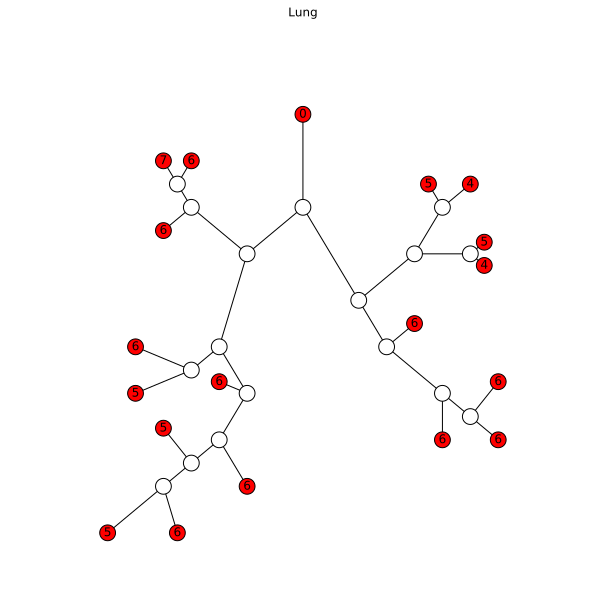

In [20]:
set_up()
update_data()

for t in range(1,time_limit+1):
    inhale()
    growth_death()
    exhale()
    update_data()
print_graph()

In [21]:
def segments_graph():
    max_y = 0
    for n in terminal_nodes:
        data_node = []
        for row in data:
            data_node.append(row[n])
        plt.plot(data_node, label=n)
        max_y = max(max_y, max(data_node))
    plt.axis([0,time_limit,0,max_y+10])
    plt.title("Bronchopulmonary segments")
    plt.legend(loc=0)
    plt.show()

In [22]:
def lobe_node_graph():

    max_y = 0
    for lobe in lobe_nodes:
        data_lobe = []
        for row in data:
            count = 0
            for node in lobe_nodes[lobe]:
                count += row[node]
            data_lobe.append(count)
        plt.plot(data_lobe, label=lobe)
        max_y = max(max_y, max(data_lobe))
    plt.axis([0,time_limit,0,max_y+10])
    plt.title("Lobes")
    plt.legend(loc=0)
    plt.show()

In [23]:
def lode_node_average_graph():
    max_y = 0
    for lobe in lobe_nodes:
        data_lobe = []
        for row in data:
            count = []
            for node in lobe_nodes[lobe]:
                count.append(row[node])
            data_lobe.append((sum(count) * 1.0)/len(count))
        plt.plot(data_lobe, label=lobe)
        max_y = max(max_y, max(data_lobe))
    plt.axis([0,time_limit,0,max_y+10])
    plt.title("Lobes (average per segment)")
    plt.legend(loc=4)
    plt.show()

In [24]:
def lung_node_graph():
    max_y = 0
    for lung in lung_nodes:
        data_lung = []
        for row in data:
            count = 0
            for node in lung_nodes[lung]:
                count += row[node]
            data_lung.append(count)
        plt.plot(data_lung, label=lung)
        max_y = max(max_y, max(data_lung))
    plt.axis([0,time_limit,0,max_y+10])
    plt.title("Lungs")
    plt.legend(loc=4)
    plt.show()

In [25]:
def lung_node_average_graph():
    max_y = 0
    for lung in lung_nodes:
        data_lung = []
        for row in data:
            counts = []
            for node in lung_nodes[lung]:
                counts.append(row[node])
            data_lung.append((sum(counts) * 1.0)/len(counts))
        plt.plot(data_lung, label=lung)
        max_y = max(max_y, max(data_lung))
    plt.axis([0,time_limit,0,max_y+10])
    plt.title("Lungs (average per segment)")
    plt.legend(loc=4)
    plt.show()

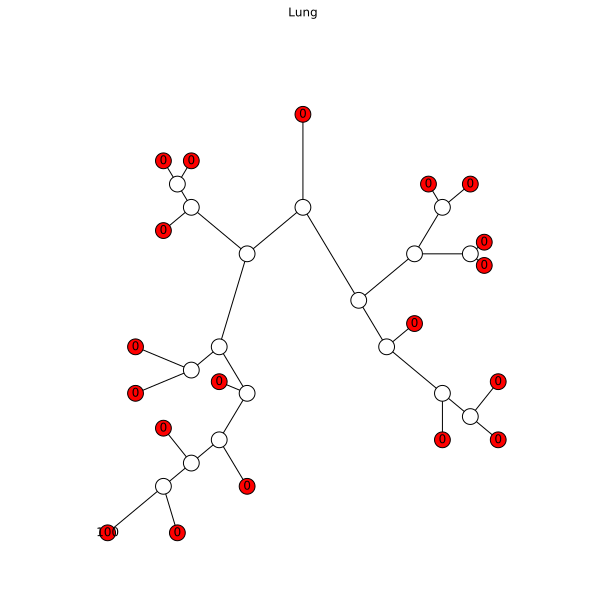

In [31]:
initial_infected_node = 26
set_up()
print_graph()
distributed_through_cough = 0.1

def cough():
    
    temp_locs = dict()
        
    for i in range(len(ordered_list)-1,-1,-1):
        index = ordered_list[i]
        node = bronchial_tree.node[index]
        if index in terminal_nodes:
            distributed_count = int(round(distributed_through_cough * node[COUNT]))
            neighbour = bronchial_tree.neighbors(index)[0]
            temp_locs[neighbour] = distributed_count
        elif index in temp_locs:
            neighbours = bronchial_tree.neighbors(index)
            new_locs = split(node, neighbours, temp_locs[index])
            # TODO : won't work - there will be 3 neighbours
            

cough()

In [ ]:
print ordered_list

In [ ]:
split_random(4,22)